### Importing initial modules

In [23]:
import numpy as np
import pandas as pd
from joblib import dump
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay

### Importing data

#### Initializing dataframe

In [5]:
df = pd.read_csv('../../datasets/data.csv')
df.head()

,filename,r_mean,g_mean,b_mean,r_std,g_std,b_std,h_mean,v_mean,h_std,v_std,quality
0,imagens/selecionadas/boa_qualidade/3391453209.jpg,132.609966,121.227249,124.231548,77.783824,69.308145,67.421205,13.189166,13.277505,20.334358,21.528245,1
1,imagens/selecionadas/boa_qualidade/3274691778.jpg,66.165817,44.555141,16.569908,69.099801,57.499889,38.438030,5.298978,7.668856,10.649066,16.816179,1
2,imagens/selecionadas/boa_qualidade/3363342011.jpg,77.994858,70.928452,81.287174,95.512351,83.056987,65.150531,4.711894,7.193683,8.418819,13.501021,1
3,imagens/selecionadas/boa_qualidade/3359563671.jpg,75.615658,79.028858,88.636810,38.806435,37.705454,40.135014,3.963080,5.991780,9.907831,13.684910,1
4,imagens/selecionadas/boa_qualidade/3307667255.jpg,112.128551,98.476761,86.907909,67.015909,65.093914,64.762853,8.664269,14.697718,14.127406,23.532887,1


#### Extracting values


In [6]:
data = (df.values)[:, 1:]

#### Splitting into attributes and targets

In [7]:
attributes = data [:, :-1]
targets = data [:, -1]

### Training model

#### Setting parameter grid for Grid Search CV

In [10]:
hiperparameters = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ["sqrt", "log2", None],
}

#### Training and collecting scores

In [11]:
fold = KFold(n_splits= 10, random_state= 0, shuffle= True)

scaler = StandardScaler()

metrics = np.zeros((10, 6))

models = [
    [-1.0, None, None],
    [2.0, None, None]
]

model = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])


In [24]:
for i, (train_index, test_index) in tqdm(enumerate(fold.split(attributes))):

    train_attributes, test_attributes = attributes[train_index], attributes[test_index]
    train_targets, test_targets = targets[train_index], targets[test_index]

    train_targets = train_targets.astype(float)
    test_targets = test_targets.astype(float)

    normal_train_attributes = scaler.fit_transform(train_attributes)
    normal_test_attributes = scaler.transform(test_attributes)

    cv = GridSearchCV(estimator=model, param_grid=hiperparameters, cv= 5, n_jobs=-1)
    cv.fit(normal_train_attributes, train_targets)
    
    model = cv.best_estimator_
    model.fit(normal_train_attributes, train_targets)
    
    prediction = model.predict(normal_test_attributes)

    acc = accuracy_score(test_targets, prediction)
    cm = confusion_matrix(test_targets, prediction, normalize='true')
    prec = precision_score(test_targets, prediction)
    rec = recall_score(test_targets, prediction)
    f1 = f1_score(test_targets, prediction)

    metrics[i] = np.array([acc, cm[0][0], cm[1][1], prec, rec, f1]).astype(float)
    
    if acc > models[0][0]:
        models[0][0] = acc
        models[0][1] = precision_recall_curve(test_targets, prediction)
        models[0][2] = cm
    elif acc < models[1][0]:
        models[1][0] = acc
        models[1][1] = precision_recall_curve(test_targets, prediction)
        models[1][2] = cm

1it [01:52, 112.14s/it]


KeyboardInterrupt: 

### Plotting Results

#### Plotting metrics through partitions, means and standard deviations

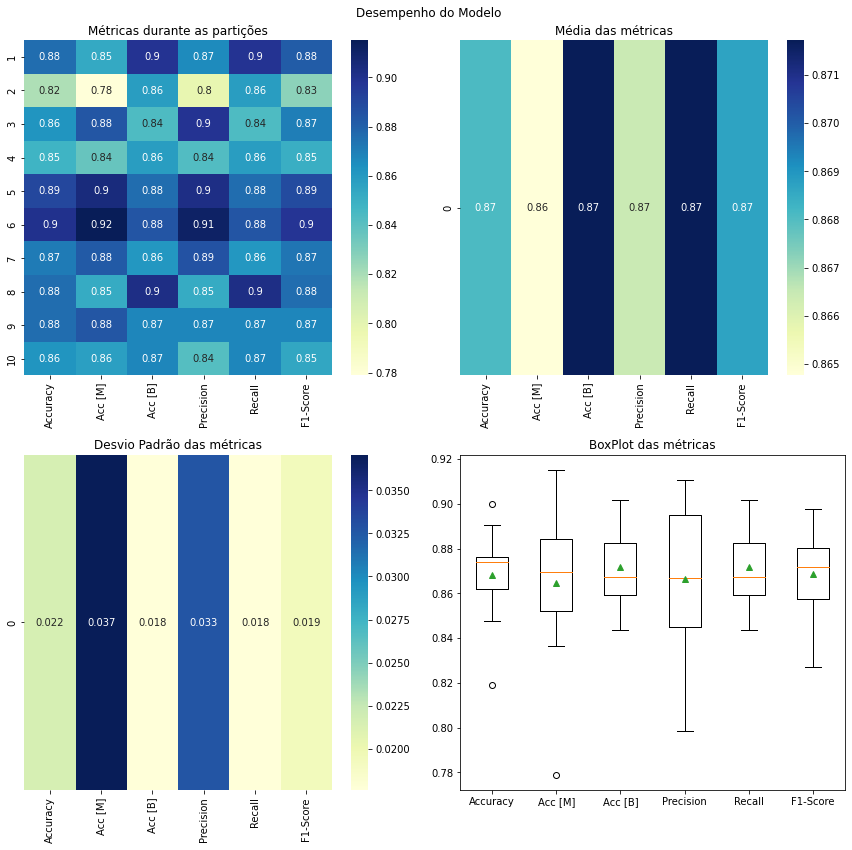

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

xlabels = ['Accuracy', 'Acc [M]', 'Acc [B]', 'Precision', 'Recall', 'F1-Score']

per_fold = sns.heatmap(metrics, annot=True, xticklabels=xlabels, yticklabels=range(1, 11), ax=ax[0][0], cmap='YlGnBu')
means = sns.heatmap(np.mean(metrics, axis=0).reshape(1, -1), annot=True, xticklabels=xlabels, ax=ax[0][1], cmap='YlGnBu')
std = sns.heatmap(np.std(metrics, axis=0).reshape(1, -1), annot=True, xticklabels=xlabels, ax=ax[1][0], cmap='YlGnBu')
ax[1][1].boxplot(metrics, labels=xlabels, showmeans=True)

fig.suptitle('Desempenho do Modelo')
ax[0][0].set_title('Métricas durante as partições')
ax[0][1].set_title('Média das métricas')
ax[1][0].set_title('Desvio Padrão das métricas')
ax[1][1].set_title('BoxPlot das métricas')

fig.tight_layout()

fig.savefig('./charts/metrics.svg')

#### Plotting Confusion Matrix and Precision-Recall curve of both best and worst models

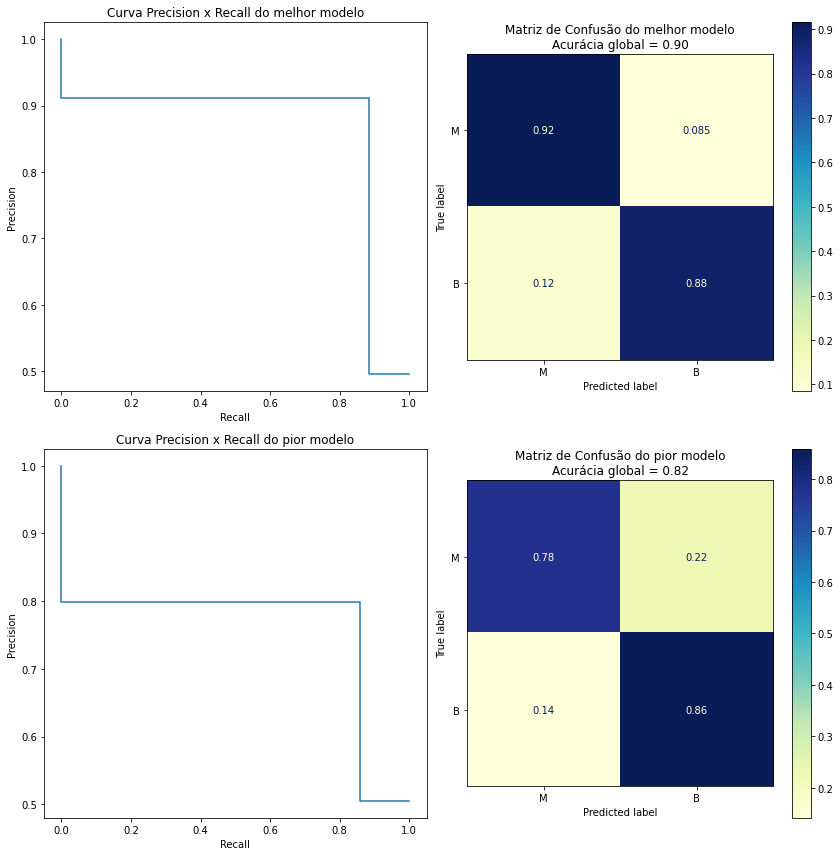

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Melhor modelo
best_precision_recall = PrecisionRecallDisplay(precision=models[0][1][0], recall=models[0][1][1])
best_confusion_m = ConfusionMatrixDisplay(models[0][2], display_labels=['M', 'B'])

# Pior modelo
worst_precision_recall = PrecisionRecallDisplay(precision=models[1][1][0], recall=models[1][1][1])
worst_confusion_m = ConfusionMatrixDisplay(models[1][2], display_labels=['M', 'B'])

best_precision_recall.plot(ax=axes[0][0])
best_confusion_m.plot(ax=axes[0][1], cmap='YlGnBu')

worst_precision_recall.plot(ax=axes[1][0])
worst_confusion_m.plot(ax=axes[1][1], cmap='YlGnBu')

axes[0][0].set_title('Curva Precision x Recall do melhor modelo')
axes[0][1].set_title(f'Matriz de Confusão do melhor modelo\nAcurácia global = {models[0][0]:.2f}')
axes[1][0].set_title('Curva Precision x Recall do pior modelo')
axes[1][1].set_title(f'Matriz de Confusão do pior modelo\nAcurácia global = {models[1][0]:.2f}')

fig.tight_layout()

fig.savefig('./charts/curves.svg')

### Training with full dataset, saving model

#### Find best hyperparameters

In [21]:
final_model = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

final_cv = GridSearchCV(estimator=final_model, param_grid=hiperparameters, cv=5, n_jobs=-1)

final_cv.fit(attributes, targets.astype(float))

best_params = final_cv.best_params_
best_params

{'rf__max_depth': 10,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 50}

#### Training with full dataset and saving model

In [22]:
final_model = RandomForestClassifier(n_estimators=best_params['rf__n_estimators'],
                                     max_depth=best_params['rf__max_depth'],
                                     min_samples_split=best_params['rf__min_samples_split'],
                                     min_samples_leaf=best_params['rf__min_samples_leaf'])

final_model.fit(attributes, targets.astype(float))

dump(final_model, './saved_models/random_forest.joblib')


['./saved_models/random_forest.joblib']